In [1]:
import os 
import numpy as np 
import tensorflow 
import random 
import sys
import argparse
import imageio 
from matplotlib import pyplot as plt
import tensorflow.compat.v1 as tf 

%matplotlib inline  

print('tensorflow version', tf.__version__)


tensorflow version 2.0.0


* Instructions 

1. Put the general model files under the `/tfserver/models/` directory 

2. Put the model weight files under the `/tfserver/models/models` directory 


In [2]:
# Import model files 
sys.path.append('./models')

from models.train import Model
from models.module import encoder, decoder
from models.img_augm import * 

from tensorflow.python.saved_model import builder as saved_model_builder
from tensorflow.python.saved_model import signature_constants
from tensorflow.python.saved_model import signature_def_utils
from tensorflow.python.saved_model import tag_constants
from tensorflow.python.saved_model import utils
from tensorflow.python.util import compat

In [3]:
# Create dummy parser 
parser = argparse.ArgumentParser()
parser.add_argument('--is_training', default=False)
parser.add_argument('--batch_size', default=1)
parser.add_argument('--image_size', default=762)
parser.add_argument('--gf_dim', default=32)
parser.add_argument('--df_dim', default=64)
options = parser.parse_args(args=[])
options


Namespace(batch_size=1, df_dim=64, gf_dim=32, image_size=762, is_training=False)

In [4]:
def normalize_arr_of_imgs(arr):
    return arr/127.5 - 1.

def denormalize_arr_of_imgs(arr):
    return (arr + 1.) * 127.5

In [5]:
# Build sess 
tf.disable_eager_execution()
sess = tf.InteractiveSession()


In [7]:
# Placeholders for sesison 
input_photo = tf.placeholder(dtype=tf.float32,shape=[1, None, None, 3],name='photo')
input_photo_features = encoder(image=input_photo,options=options,reuse=False)
output_photo = decoder(features=input_photo_features,options=options,reuse=False)
saver = tf.train.Saver(max_to_keep=2)

# Activate variables
sess.run(tf.global_variables_initializer())

# Seeing WARNING here is normal, since tf1 in some case is nolonger supported


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
encoder
decode


In [8]:
# Load weight 
model_name = 'francoise'
checkpoint_dir = './models/models/model_{}/checkpoint_long/'.format(model_name)
ckpt = tf.train.get_checkpoint_state(checkpoint_dir)
ckpt_name = os.path.basename(ckpt.model_checkpoint_path)
saver.restore(sess, os.path.join(checkpoint_dir, ckpt_name))

INFO:tensorflow:Restoring parameters from ./models/models/model_francoise/checkpoint_long/model_francoise_60000.ckpt-60000


In [9]:
# Read in data 
content_photo =  'test_input_img1.jpg'
target_photo = 'test_output_{}_img1.jpg'.format(model_name)

input_img = imageio.imread(content_photo)
input_img = np.expand_dims(input_img, axis=0)


In [10]:
# Run session 
output_img = denormalize_arr_of_imgs(
    sess.run(
    output_photo, 
    feed_dict={
        input_photo: normalize_arr_of_imgs(input_img)
    }
)
)


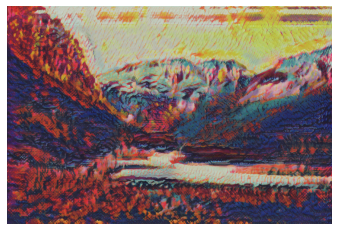

In [11]:
# Show output 
plt.figure()
plt.axis('off')
plt.imshow(output_img[0].astype(np.uint8))
plt.show()


In [12]:
# Save Models 
tensor_info_input_photo = utils.build_tensor_info(input_photo)
tensor_info_output_photo = utils.build_tensor_info(output_photo)

generate_signature = signature_def_utils.build_signature_def(
      inputs={'input_img': tensor_info_input_photo},
      outputs={'output_img': tensor_info_output_photo},
      method_name=signature_constants.PREDICT_METHOD_NAME)

# Save model 
export_style_transfer_path = './servable/{}/1'.format(model_name)
builder = saved_model_builder.SavedModelBuilder(export_style_transfer_path)
builder.add_meta_graph_and_variables(
    sess, [tag_constants.SERVING],
    signature_def_map={'predict_images':generate_signature,}
    )
builder.save()


Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.utils.build_tensor_info or tf.compat.v1.saved_model.build_tensor_info.
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ./servable/francoise/1/saved_model.pb


b'./servable/francoise/1/saved_model.pb'

In [13]:
# Check saved model for basic info 
!saved_model_cli show --dir {export_style_transfer_path} --all



MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['predict_images']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['input_img'] tensor_info:
        dtype: DT_FLOAT
        shape: (1, -1, -1, 3)
        name: photo_1:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['output_img'] tensor_info:
        dtype: DT_FLOAT
        shape: (1, -1, -1, 3)
        name: decoder/sub:0
  Method name is: tensorflow/serving/predict
